## Part 1 - Article Sentiment information extraction 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
import re
import csv 
import nltk
import warnings
import yfinance as yf
import xgboost as xgb
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import trainer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ball4308/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


* Data Loading and pre-processing

In [2]:
dfv = pd.read_csv("df_transed_cleaned.csv").drop(columns = ['Unnamed: 0'])
dfv['publish_date'] = pd.to_datetime(dfv['publish_date'])
dfv['date'] = dfv['publish_date'].apply(lambda x: x.date())
dfv = dfv.drop(columns =['translateda_mix','translateda_headline','translateda_headline_cleaned',
                         'translateda_mix_dic','translateda_headline_dic'])
dfv = dfv.rename(columns = {'translateda_mix_cleaned':'transated_mix_cleaned'})                    
dfv.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,scraped_article,title_FB_only,BOG,date,transated_mix_cleaned
0,865782065,2015-01-03 18:12:00,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",https://twitter.com/TheRalphRetort/status/5515...,en,False,NaN,18346,Twitter,http://twitter.com,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",NaN,NaN,2015-01-03,ralph twitter appreciate big help
1,335784736,2015-01-07 07:23:39,The Daily Rupert on Twitter: &quot;Facebook v...,https://twitter.com/TheMurdochTimes/status/552...,en,False,NaN,18346,Twitter,http://twitter.com,The Daily Rupert on Twitter: &quot;Facebook v...,NaN,NaN,2015-01-07,daily twitter video image terrorist outside of...
2,335817091,2015-01-07 12:32:58,teleSUR TV on Twitter: &quot;El Festival de Ca...,https://twitter.com/teleSURtv/status/552880585...,en,False,NaN,18346,Twitter,http://twitter.com,teleSUR TV on Twitter: &quot;El Festival de Ca...,NaN,NaN,2015-01-07,twitter festival de en en
3,320258910,2015-01-15 21:39:09,Stop Patriarchy on Twitter: &quot;Tune in to n...,https://twitter.com/StopPatriarchy/status/5559...,en,False,NaN,18346,Twitter,http://twitter.com,Stop Patriarchy on Twitter: &quot;Tune in to n...,NaN,NaN,2015-01-15,stop patriarchy twitter join event
4,372077690,2015-01-24 07:00:00,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,https://archive.is/ArtrI,en,False,computers and the internet,18346,Twitter,http://twitter.com,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,NaN,NaN,2015-01-24,blocker twitter kop could not keep mouth shut ...


In [3]:
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7732 entries, 0 to 7731
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   stories_id             7732 non-null   int64         
 1   publish_date           7729 non-null   datetime64[ns]
 2   title                  7732 non-null   object        
 3   url                    7732 non-null   object        
 4   language               7716 non-null   object        
 5   ap_syndicated          7732 non-null   bool          
 6   themes                 1478 non-null   object        
 7   media_id               7732 non-null   int64         
 8   media_name             7732 non-null   object        
 9   media_url              7732 non-null   object        
 10  scraped_article        7732 non-null   object        
 11  title_FB_only          3928 non-null   object        
 12  BOG                    3928 non-null   object        
 13  dat

* Thanks for Jason's article published on Towards Data Science (https://towardsdatascience.com/https-towardsdatascience-com-algorithmic-trading-using-sentiment-analysis-on-news-articles-83db77966704) , we can use the lexicon based sentiment analyser that he has demonstrated to convert the clenaed article into 

* The Loughran and McDonald lexicon represent the vocabulary standing for positive and negative sentiment in the financial market. The update process is shown in Cell 5.

In [4]:
# # stock market lexicon
stock_lex = pd.read_csv("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/stock_lex.csv")
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
     if v > 0:
         stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
     else:
         stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

In [5]:
### Loughran and McDonald
positive = []
with open("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/lm_positive.csv", 'r') as f:
     reader = csv.reader(f)
     for row in reader:
         positive.append(row[0].strip())
    
negative = []
with open("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/lm_negative.csv", 'r') as f:
     reader = csv.reader(f)
     for row in reader:
         entry = row[0].strip().split(" ")
         if len(entry) > 1:
             negative.extend(entry)
         else:
             negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

* Use aggregation function to calculate compounded score of stock sentiment on a daily basis. 

* The compounded score is on a scale from -1 to 1, from negative to positive

In [6]:
dfv['transated_mix_cleaned'] = dfv['transated_mix_cleaned'].astype(str)
dfv['article_sentiment'] =  dfv['transated_mix_cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [7]:
senti_score = dfv.groupby('date')[['article_sentiment']].mean()
senti_score.head()

,article_sentiment
date,
2015-01-03,0.8320
2015-01-07,-0.2196
2015-01-15,0.1662
2015-01-24,0.0579
2015-02-05,0.3473


In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(senti_score.index), y = senti_score['article_sentiment'],
                    mode='lines',
                    name='sarticle sentiment'))

fig.show()

In [9]:
finance = pd.read_csv('financial_wiki_2017_07_08.csv')
finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     1282 non-null   object 
 1   Facebook.wiki            1282 non-null   float64
 2   Google.wiki              1282 non-null   float64
 3   Microsoft.wiki           1282 non-null   float64
 4   Apple Inc..wiki          1282 non-null   float64
 5   AAPL                     1282 non-null   float64
 6   AMZN                     1282 non-null   float64
 7   FB                       1282 non-null   float64
 8   GOOGL                    1282 non-null   float64
 9   MSFT                     1282 non-null   float64
 10  FB_return                1282 non-null   float64
 11  GOOGL_return             1282 non-null   float64
 12  MSFT_return              1282 non-null   float64
 13  AMZN_return              1282 non-null   float64
 14  AAPL_return             

In [10]:
finance.head()

,Date,Facebook.wiki,Google.wiki,Microsoft.wiki,Apple Inc..wiki,AAPL,AMZN,FB,GOOGL,MSFT,...,Facebook.wiki_t-3_t-4,Google.wiki_t-1_t-2,Google.wiki_t-2_t-3,Google.wiki_t-3_t-4,Microsoft.wiki_t-1_t-2,Microsoft.wiki_t-2_t-3,Microsoft.wiki_t-3_t-4,Apple Inc..wiki_t-1_t-2,Apple Inc..wiki_t-2_t-3,Apple Inc..wiki_t-3_t-4
0,2015-07-08,10.723355,10.725951,9.256556,9.585690,28.189571,429.700012,85.650002,541.700012,39.941715,...,0.669849,0.024664,-0.024287,-0.016310,0.003597,-0.023742,0.025345,0.142520,-0.040248,0.054003
1,2015-07-09,10.762213,10.675816,9.190852,9.527047,27.614601,434.390015,85.879997,544.650024,40.194511,...,-0.746695,-0.046652,0.024664,-0.024287,0.331367,0.003597,-0.023742,0.074801,0.142520,-0.040248
2,2015-07-10,10.749849,10.660853,8.964056,9.425048,28.352858,443.510010,87.949997,556.109985,40.275764,...,-0.022031,-0.050135,-0.046652,0.024664,-0.065704,0.331367,0.003597,-0.058643,0.074801,0.142520
3,2015-07-13,10.759264,10.701850,8.969287,9.431883,28.900230,455.570007,90.099998,571.729980,41.115414,...,-0.011409,-0.014963,-0.050135,-0.046652,-0.226796,-0.065704,0.331367,-0.101999,-0.058643,0.074801
4,2015-07-14,10.703447,10.720400,8.897682,9.345570,28.888727,465.570007,89.680000,584.179993,41.187630,...,0.038857,0.040997,-0.014963,-0.050135,0.005231,-0.226796,-0.065704,0.006834,-0.101999,-0.058643


In [11]:
wiki_f = ['Facebook.wiki','Google.wiki','Microsoft.wiki','Apple Inc..wiki']
stock_f = ['AAPL','AMZN','FB','GOOGL','MSFT']
stock_f_r = [x + '_return' for x in stock_f if x != 'FB']
finance_c = finance.drop(columns = wiki_f + stock_f + stock_f_r )
finance_c.head()

,Date,FB_return,Facebook.wiki_t-1,Facebook.wiki_t-2,Facebook.wiki_t-3,Google.wiki_t-1,Google.wiki_t-2,Google.wiki_t-3,Microsoft.wiki_t-1,Microsoft.wiki_t-2,...,Facebook.wiki_t-3_t-4,Google.wiki_t-1_t-2,Google.wiki_t-2_t-3,Google.wiki_t-3_t-4,Microsoft.wiki_t-1_t-2,Microsoft.wiki_t-2_t-3,Microsoft.wiki_t-3_t-4,Apple Inc..wiki_t-1_t-2,Apple Inc..wiki_t-2_t-3,Apple Inc..wiki_t-3_t-4
0,2015-07-08,-0.018000,10.734765,10.756796,11.503491,10.772603,10.747939,10.772225,8.925188,8.921591,...,0.669849,0.024664,-0.024287,-0.016310,0.003597,-0.023742,0.025345,0.142520,-0.040248,0.054003
1,2015-07-09,0.002685,10.723355,10.734765,10.756796,10.725951,10.772603,10.747939,9.256556,8.925188,...,-0.746695,-0.046652,0.024664,-0.024287,0.331367,0.003597,-0.023742,0.074801,0.142520,-0.040248
2,2015-07-10,0.024103,10.762213,10.723355,10.734765,10.675816,10.725951,10.772603,9.190852,9.256556,...,-0.022031,-0.050135,-0.046652,0.024664,-0.065704,0.331367,0.003597,-0.058643,0.074801,0.142520
3,2015-07-13,0.024446,10.749849,10.762213,10.723355,10.660853,10.675816,10.725951,8.964056,9.190852,...,-0.011409,-0.014963,-0.050135,-0.046652,-0.226796,-0.065704,0.331367,-0.101999,-0.058643,0.074801
4,2015-07-14,-0.004661,10.759264,10.749849,10.762213,10.701850,10.660853,10.675816,8.969287,8.964056,...,0.038857,0.040997,-0.014963,-0.050135,0.005231,-0.226796,-0.065704,0.006834,-0.101999,-0.058643


In [12]:
finance_c = finance_c.set_index('Date')
finance_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1282 entries, 2015-07-08 to 2020-08-07
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FB_return                1282 non-null   float64
 1   Facebook.wiki_t-1        1282 non-null   float64
 2   Facebook.wiki_t-2        1282 non-null   float64
 3   Facebook.wiki_t-3        1282 non-null   float64
 4   Google.wiki_t-1          1282 non-null   float64
 5   Google.wiki_t-2          1282 non-null   float64
 6   Google.wiki_t-3          1282 non-null   float64
 7   Microsoft.wiki_t-1       1282 non-null   float64
 8   Microsoft.wiki_t-2       1282 non-null   float64
 9   Microsoft.wiki_t-3       1282 non-null   float64
 10  Apple Inc..wiki_t-1      1282 non-null   float64
 11  Apple Inc..wiki_t-2      1282 non-null   float64
 12  Apple Inc..wiki_t-3      1282 non-null   float64
 13  FB_return_t-1            1282 non-null   float64
 14  FB_return_t-2 

In [13]:
 senti_score.index = pd.to_datetime(senti_score.index)

In [14]:
finance_c.index = pd.to_datetime(finance_c.index)

In [15]:
data = finance_c.merge(senti_score, left_index = True, right_index = True, how = 'left')
data = data.fillna(0)

In [16]:
print(data.shape)

(1282, 41)


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1282 entries, 2015-07-08 to 2020-08-07
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FB_return                1282 non-null   float64
 1   Facebook.wiki_t-1        1282 non-null   float64
 2   Facebook.wiki_t-2        1282 non-null   float64
 3   Facebook.wiki_t-3        1282 non-null   float64
 4   Google.wiki_t-1          1282 non-null   float64
 5   Google.wiki_t-2          1282 non-null   float64
 6   Google.wiki_t-3          1282 non-null   float64
 7   Microsoft.wiki_t-1       1282 non-null   float64
 8   Microsoft.wiki_t-2       1282 non-null   float64
 9   Microsoft.wiki_t-3       1282 non-null   float64
 10  Apple Inc..wiki_t-1      1282 non-null   float64
 11  Apple Inc..wiki_t-2      1282 non-null   float64
 12  Apple Inc..wiki_t-3      1282 non-null   float64
 13  FB_return_t-1            1282 non-null   float64
 14  FB_ret

## Part 2 - Modelling & Parameter tunning

* Define Loss funciton/evaluation metric: Mean absolute percentage error

* This is very important since MAE and MSE only provides aboslute measure, instead or relative measure of residuals 

In [18]:
def MAPE(true, pred): 

    y_true, y_pred = np.array(true), np.array(pred)

    return round(abs((y_true- y_pred)/y_true).mean() * 100,4)

* Train-test split 

In [19]:
train_test_split = 0.80
total_days = len(data.index)
split_week = data.index[round(total_days*(train_test_split))]
train = data[data.index <= split_week]
test = data[data.index > split_week]
print(split_week)
print(train.shape)
print(test.shape)

2019-08-05 00:00:00
(1027, 41)
(255, 41)


In [20]:
from sklearn.preprocessing import StandardScaler
x_sc = StandardScaler()
y_sc = StandardScaler()

* We use return as target variable here and calculate the stock prediction based on the predicted return. If we use the actual stock price, we are running the risk of not providing training set enough range of target variable, thus the model will not work in the deployment phase 

* An interesting development is Catboost (https://towardsdatascience.com/introduction-to-gradient-boosting-on-decision-trees-with-catboost-d511a9ccbd14), which can hanlde this probelm.

In [21]:
train_X, train_y = train.drop(columns = ['FB_return']), train['FB_return']

In [22]:
test_X, test_y = test.drop(columns = ['FB_return']), test['FB_return']

In [23]:
train_X_sc, train_y_sc = x_sc.fit_transform(train_X), y_sc.fit_transform(train_y.values.reshape(-1, 1))
test_X_sc, test_y_sc = x_sc.transform(test_X), y_sc.transform(test_y.values.reshape(-1, 1))

In [24]:
print(train_X_sc.shape, train_y_sc.shape)
print(test_X_sc.shape, test_y_sc.shape)

(1027, 40) (1027, 1)
(255, 40) (255, 1)


* Define time-series split to performe time series cross validation 

* Here we start a step-by-step demo of using LGBM first and then package every thing into trainer.py 

In [25]:
time_split = TimeSeriesSplit(n_splits=5)
reg1 = lgb.LGBMRegressor()

In [26]:
grid = {'num_leaves': [int(x) for x in np.logspace(start = 3, stop = 5 , num=5, base = 2)], 
        'learning_rate': np.linspace(0.05,0.5,5)}
RCV = GridSearchCV(estimator=reg1 , 
                   param_grid= grid, 
                   scoring='neg_mean_squared_error', 
                   n_jobs=-1, 
                   cv=time_split, 
                   verbose=-1)
RCV.fit(train_X_sc,train_y_sc)              

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   28.8s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.05  , 0.1625, 0.275 , 0.3875, 0.5   ]),
                         'num_leaves': [8, 11, 16, 22, 32]},
             scoring='neg_mean_squared_error', verbose=-1)

In [27]:
RCV.best_estimator_

LGBMRegressor(learning_rate=0.05, num_leaves=32)

In [28]:
RCV.best_score_

-1.0539222895056548

* Training performance evaluation

In [29]:
temp = yf.download('FB', start='2015-07-07', end='2015-07-09')['Adj Close']
temp

[*********************100%***********************]  1 of 1 completed


Date
2015-07-06    87.550003
2015-07-07    87.220001
2015-07-08    85.650002
Name: Adj Close, dtype: float64

In [30]:
lis = [temp['2015-07-07']] + list(finance[finance['Date'] >= '2015-07-08'][finance['Date'] <= '2019-08-02']['FB'])
print(len(lis))

1027


In [31]:
fb_t_1_tr = pd.Series(lis)
fb_true_tr = finance[finance['Date'] >= '2015-07-08'][finance['Date'] <= '2019-08-05']['FB']

In [32]:
yhat_return_sc_tr = RCV.best_estimator_.predict(train_X_sc)
yhat_return_tr =  y_sc.inverse_transform(yhat_return_sc_tr) 
yhat_stock_tr = (yhat_return_tr + 1) * fb_t_1_tr
print('mean squared error {}'.format(mean_squared_error(fb_true_tr, yhat_stock_tr))) 
print('mean absolute error {}'.format(mean_absolute_error(fb_true_tr, yhat_stock_tr))) 
print('mean absolute percentage error(%) {}'.format(MAPE(fb_true_tr, yhat_stock_tr)))

mean squared error 2.233173544441005
mean absolute error 0.7239860325632342
mean absolute percentage error(%) 0.5008


* Prediction performance evaluation 

In [33]:
fb_t_1 = finance[finance['Date'] >= '2019-08-05'][finance['Date'] <= '2020-08-06']['FB']
fb_true = finance[finance['Date'] >= '2019-08-06'][finance['Date'] <= '2020-08-07']['FB']

In [34]:
yhat_return_sc = RCV.best_estimator_.predict(test_X_sc)
yhat_return =  y_sc.inverse_transform(yhat_return_sc) 
yhat_stock = (yhat_return + 1) * fb_t_1
print('mean squared error {}'.format(mean_squared_error(fb_true, yhat_stock))) 
print('mean absolute error {}'.format(mean_absolute_error(fb_true, yhat_stock))) 
print('mean absolute percentage error(%) {}'.format(MAPE(fb_true, yhat_stock)))

mean squared error 26.0007385236958
mean absolute error 3.5690892121624342
mean absolute percentage error(%) 1.827


In [35]:
yhat_stock.index = test.index
fb_true.index = test.index

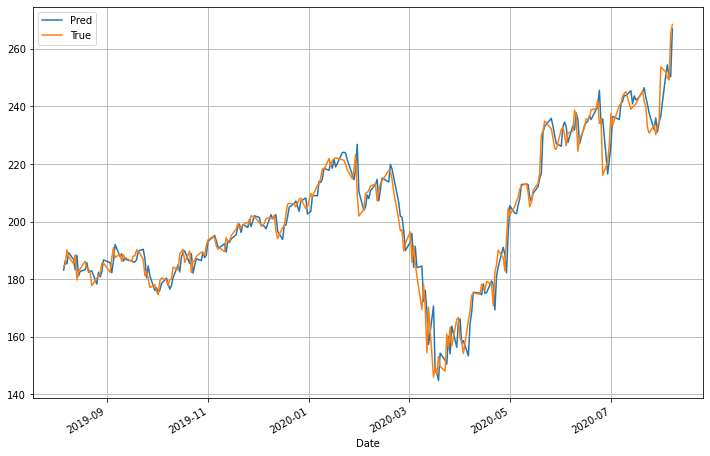

In [36]:
plt.figure(figsize=(12, 8))
yhat_stock.plot(label = 'Pred')
fb_true.plot(label = 'True')
plt.legend()
plt.grid()

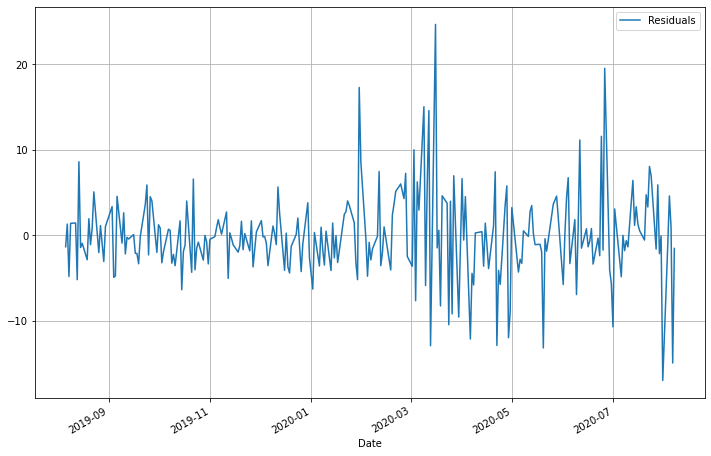

In [37]:
plt.figure(figsize=(12, 8))
(yhat_stock - fb_true).plot(label = 'Residuals')
plt.legend()
plt.grid()

* Evaluation with XG boosting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   13.9s finished
[17:20:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best estimator XGBRegressor(learning_rate=0.05, num_leaves=8)
Best score of grid search -1.0196788066833808
[*********************100%***********************]  1 of 1 completed
mean squared error 4.921640369791457
mean absolute error 1.5150825828879946
mean absolute percentage error(%) 1.0445
mean squared error 27.541369896687574
mean absolute error 3.5751040905572102
mean absolute percentage error(%) 1.8241
Plot Pred vs True on test set


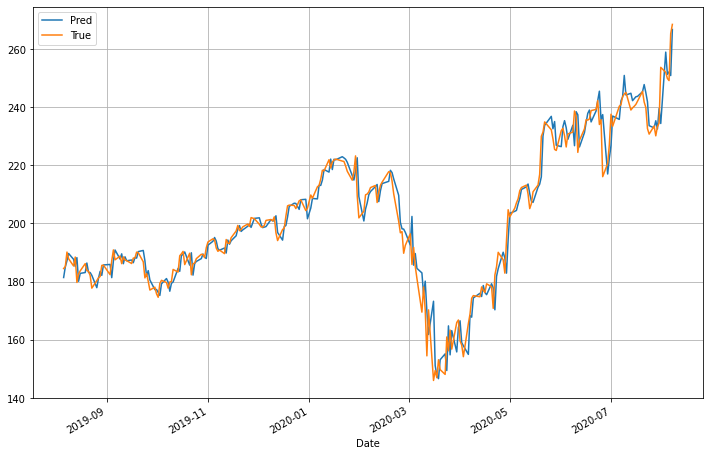

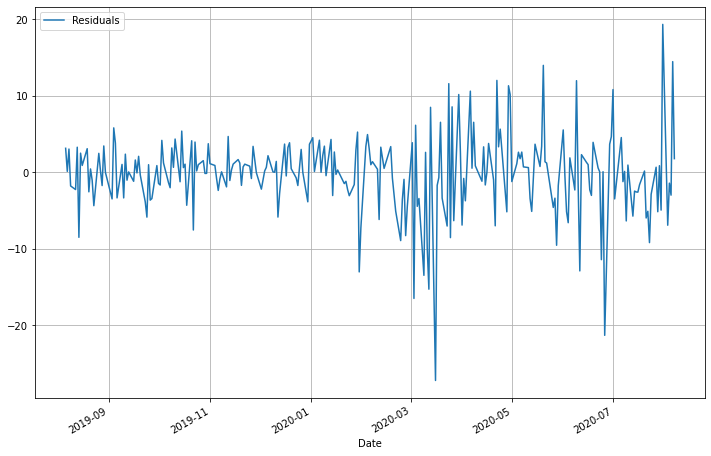

In [38]:
reg = xgb.XGBRegressor()
grid = {'num_leaves': [int(x) for x in np.logspace(start = 3, stop = 5 , num=5, base = 2)], 
        'learning_rate': np.linspace(0.05,0.5,5)}
yhat_stock_2, fb_true_2, xgboost = trainer.train_test_perfornace(reg, grid, finance, train_X_sc, train_y_sc, test_X_sc, test_y_sc,train, test, y_sc, time_split)

##  Part 3 - Reflection 

## 1. 

We have observed overfitting for both models, although we only have 8 leaves in our XG bosst decision trees and 32 leaves in the LGBM trees. Considering using a simplier model for comparison. (i.e. Kernel Ridge)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.1s finished
Best estimator KernelRidge(alpha=1024, kernel='rbf')
Best score of grid search -0.8987137128686736
[*********************100%***********************]  1 of 1 completed
mean squared error 8.035637282502146
mean absolute error 1.7656373400999232
mean absolute percentage error(%) 1.2187
mean squared error 24.86427403613822
mean absolute error 3.4009728764806058
mean absolute percentage error(%) 1.7439
Plot Pred vs True on test set


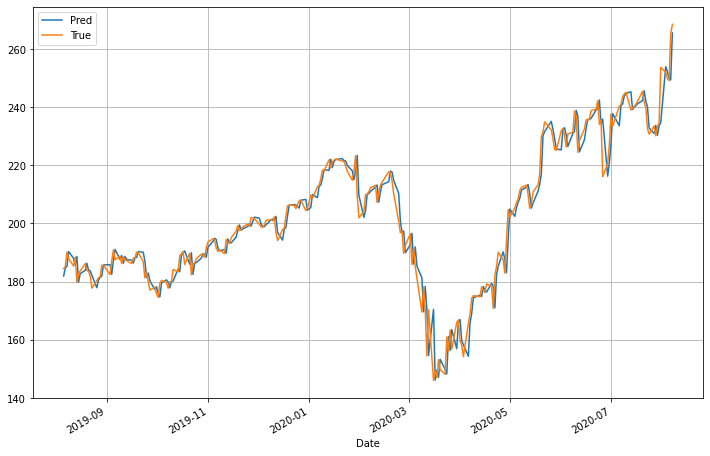

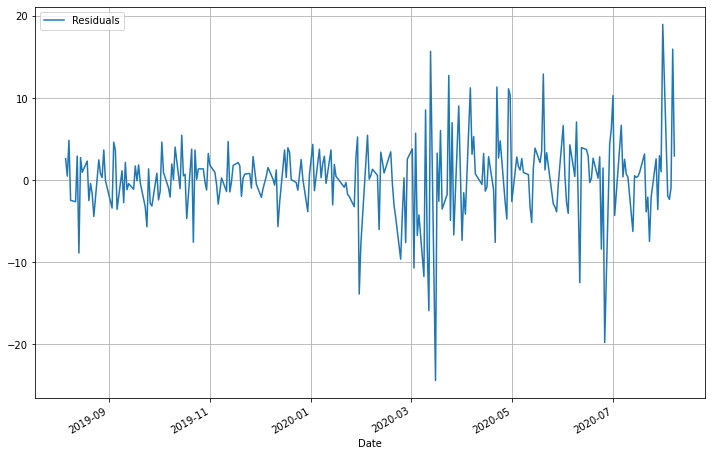

In [39]:
reg3 = KernelRidge()
grid3 = {'alpha': [int(x) for x in np.logspace(start = 1, stop = 10, num=10, base = 2)], 
        'kernel': ['rbf','polynomial','linear']}
yhat_stock_3, fb_true_3, kernel_ridge = trainer.train_test_perfornace(reg3, grid3, finance, train_X_sc, train_y_sc, test_X_sc, test_y_sc, train, test, y_sc, time_split)

* Via using Kernel Ridge, we have successfully reduced the overfitting

## 2. 

For both XG bossting, LGBM and Kernel Ridge, we have observed higher and growing residuals when the time moves beyond 2020 February,indicating that the predictors are losing predictive power. 

This is actually intuitive, since Stock price is affected by wide range of factors, what used to work before may not consistently work well in the future. We recommend to use these features as a 5 month forecasting model (Aug 2019 to Jan 2020), instead of a full-year one. 

This reflection also works for forecasting for retailers, and almost for any time-series problems. Feature re-engineering / Feature re-selection should be carried after a while, no matter through a mannual process or through automated algorithm process

## 3. 

Although XG boosting does not performe as well as LGBM in one-year forecasting we have observed that XG Boosting performs much better than LGBM before 2020 February, as shown below the differnce of MSE is obvious. And it turns out that RBF kernel Ridge is the best candidate model for the forecasting

In [40]:
xg_mse = mean_squared_error(yhat_stock_2[yhat_stock_2.index <= '2020-02-01'], fb_true_2[fb_true_2.index <= '2020-02-01'])
print(xg_mse)

9.09393987652459


In [41]:
lgbm_mse = mean_squared_error(yhat_stock[yhat_stock.index <= '2020-02-01'], fb_true[fb_true.index <= '2020-02-01'])
print(lgbm_mse)

11.226729278040308


In [42]:
Ridge_mse = mean_squared_error(yhat_stock_3[yhat_stock_3.index <= '2020-02-01'], fb_true_3[fb_true_3.index <= '2020-02-01'])
print(Ridge_mse)

8.949875010341428


* Visulalise the relative feature importance to understand which predictors are important 

* LGB

In [43]:
RCV.best_estimator_.fit(train_X_sc, train_y_sc)

LGBMRegressor(learning_rate=0.05, num_leaves=32)

In [44]:
importance_value = RCV.best_estimator_.feature_importances_
importance_name = train_X.columns

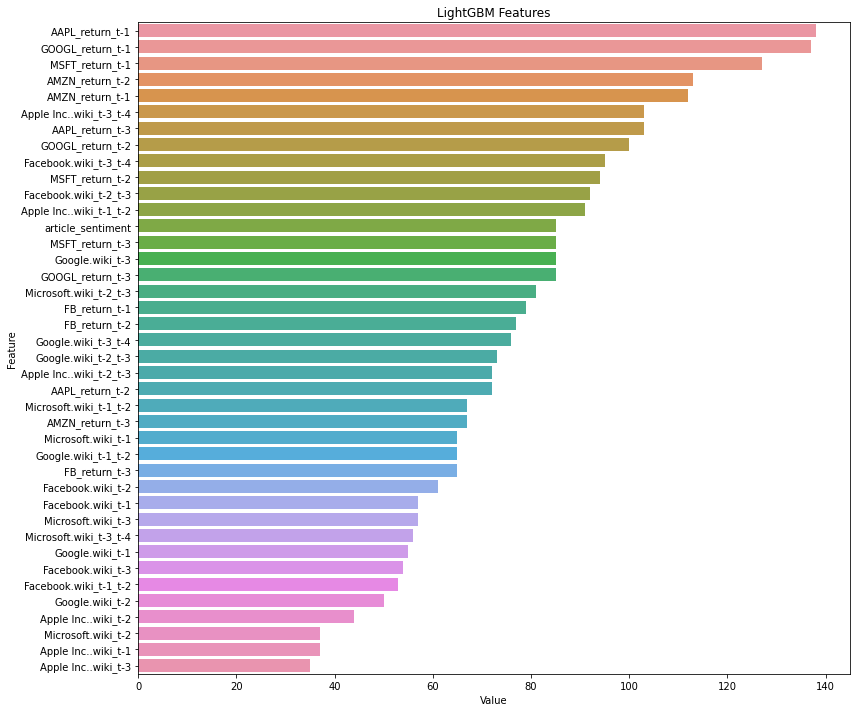

In [45]:
feature_imp = pd.DataFrame(sorted(zip(importance_value , importance_name)), columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

* XGBOOST 

In [46]:
xgboost.best_estimator_.fit(train_X_sc, train_y_sc)
importance_value = xgboost.best_estimator_.feature_importances_
importance_name = train_X.columns

[17:20:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


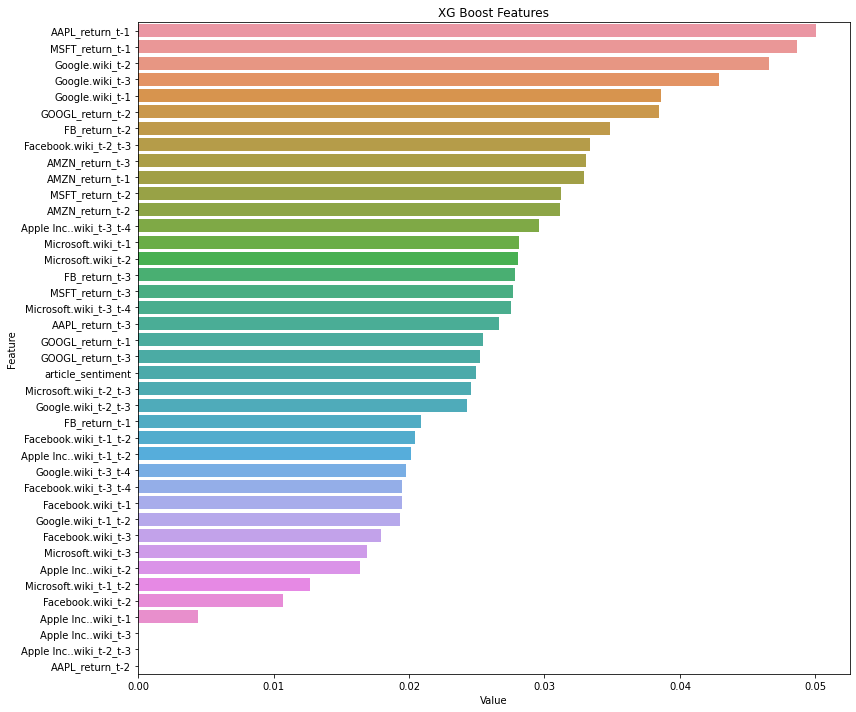

In [47]:
feature_imp = pd.DataFrame(sorted(zip(importance_value , importance_name)), columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XG Boost Features')
plt.tight_layout()
plt.show()

* KRR, we need to calculate the weight on each predictor first and then visualaise them

In [48]:
ridge = kernel_ridge.best_estimator_
ridge.fit(train_X_sc, train_y_sc)

KernelRidge(alpha=1024, kernel='rbf')

In [49]:
a = ridge.dual_coef_
w = np.dot(train_X_sc.T,a)
w = [x[0] for x in w]
print(len(w))

40


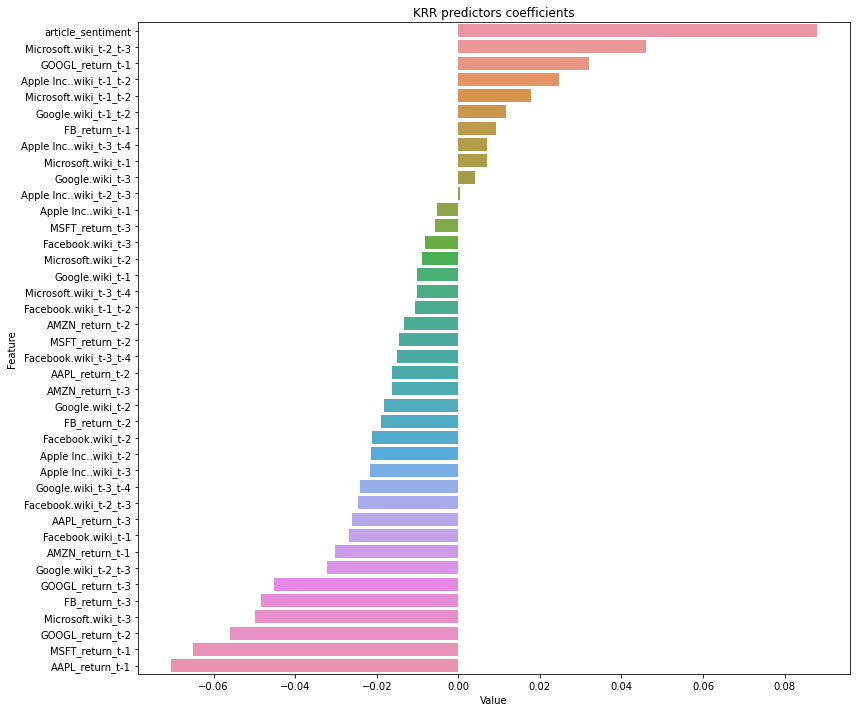

In [50]:
coef = pd.DataFrame(sorted(zip(w , train_X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=coef.sort_values(by="Value", ascending=False))
plt.title('KRR predictors coefficients')
plt.tight_layout()
plt.show()

* We have found that: 

(1) Article sentiment represented by Vader is important in KRR and LGBM, with its importance slightly reduced in XG boosting

(2) Financial returns are more important than Wikipedia page view on average

(3) Financial returns of related stock on t-1 days are very important among three models 

(4) The differnce between t-2 and t-3 days' and t-3 and t-4 days' Wikipedia Page view of Facebook stock are important predictors if we are only look at Facebook itself

### Part 4 - Limitations and Future effort

1. Feature selection process can be carried in a more robust fahison, making use of VIF or Boruta 

2. Predicting return first and calculate the actual stock is an option given the models that we have tried, but it will amplify the error when we translate return back to stock price. Catboosting is the next step for generating more accurate forecast